# GEOG5990M Final Assignment (Template)

Student ID number: 201896942

房价数据——有邮编

小邮编区的住房中心点数据

LSoa数据

思路：

对于房价数据，使用邮编字段进行链接

Lsoa数据使用字段筛选出属于大都会区的所有lsoa

本研究致力于使用曼彻斯特大都会地区的房价数据以及各房产的交通可达性数据来探索房屋售价

In [34]:
# import required packages
# for visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# for data manipulation
import pandas as pd
import numpy as np

# import any further required packages
#!pip install contextily
#!pip install geoplot
#!pip install git+https://github.com/pmdscully/geo_northarrow.git

import geopandas as gpd
import pyproj
import contextily as ctx

import geoplot as gplt
import geoplot.crs as gcrs
from geo_northarrow import add_north_arrow
from shapely.geometry import Point

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

首先加载房价数据

数据来源于：Statistical data set

Price Paid Data

https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads#march-2025-data-current-month

为2025年1-3月全英所有成交的房屋记录


下一步进行数据加载，首先加载房价数据然后显示前5行来观察数据的构成

In [5]:
from google.colab import drive
# 步骤2: 挂载Google Drive
drive.mount('/content/drive')
hpall = pd.read_csv('/content/drive/MyDrive/Python_final/pp-2025.csv')
hpall.head()

Mounted at /content/drive


,Transaction unique identifier,Price,Date of Transfer,Postcode,Property Type,Old/New,Duration,PAON,SAON,Street,Locality,Town/City,District,County,PPD Category Type,Record Status
0,{31C68072-988E-FEE3-E063-4804A8C04F37},320000,2025/2/28 0:00,KT20 5SJ,F,N,L,21,NaN,CORNER FARM CLOSE,NaN,TADWORTH,REIGATE AND BANSTEAD,SURREY,A,A
1,{31C68072-988F-FEE3-E063-4804A8C04F37},423500,2025/2/14 0:00,RH1 3LS,S,N,F,36,NaN,ALBURY ROAD,MERSTHAM,REDHILL,REIGATE AND BANSTEAD,SURREY,A,A
2,{31C68072-9891-FEE3-E063-4804A8C04F37},525000,2025/2/13 0:00,GU18 5AA,D,N,F,20,NaN,CONISTON COURT,NaN,LIGHTWATER,SURREY HEATH,SURREY,A,A
3,{31C68072-9892-FEE3-E063-4804A8C04F37},845000,2025/3/24 0:00,RH1 4JA,D,N,F,NUTFIELD COURT,2,CHURCH HILL,NUTFIELD,REDHILL,TANDRIDGE,SURREY,A,A
4,{31C68072-9893-FEE3-E063-4804A8C04F37},225000,2025/2/24 0:00,GU15 2EH,F,N,L,"BENTLEY COURT, 33",FLAT 3,UPPER GORDON ROAD,NaN,CAMBERLEY,SURREY HEATH,SURREY,A,A


可以观察到对于此项目研究的课题，其中有很多冗余信息

首先要使用county字段筛选出man内的房屋交易数据，然后去掉多余字段，只保留房价、邮编以及一些房产参数。而且观察到房产交易信息中并不包含空间数据。跟较为准确的地理位置相关的信息只有邮编，因此后续需要进一步通过邮编数据来为房价信息增加空间属性。

In [ ]:
#hpall.info()
#hpall.describe()

从https://osdatahub.os.uk/downloads/open/CodePointOpen搜集到了不同的邮编对应的坐标点的数据
对于标有PQI(定位质量指标)为10的邮政编码，其"中心点"是通过以下算法计算的：首先，计算该邮政编码单元内所有地址的坐标平均值，获得一个平均位置；然后，该邮政编码的中心点坐标被设定为该邮政编码单元内最接近这个平均位置的实际地址的坐标。
对于您的研究来说，这个数据非常适合，因为它确实提供了每个邮政编码区域的中心点坐标，而不仅仅是一个粗略的位置。这意味着您可以利用这些数据点计算到最近公共交通站点的距离，获得相对准确的可达性测量。
您需要注意的是，虽然这些中心点非常精确，但它们并不一定是邮政编码区域的几何中心，而是基于该区域内实际地址分布计算出的点。这对您的研究实际上是有利的，因为它们更好地代表了人们实际居住的位置。



In [14]:
#加载邮编坐标点数据postcode position
pcptall = gpd.read_file('/content/drive/MyDrive/Python_final/codepo_gb.gpkg')

# 直接读取Shapefile，不用先定义路径变量
lsoa_all = gpd.read_file('/content/drive/MyDrive/Python_final/BoundaryData/england_lsoa_2021.shp')

In [15]:
#筛选man的lsoa
# 定义大曼彻斯特的所有地区名称
gm_areas = ['Manchester', 'Salford', 'Bolton', 'Bury', 'Oldham',
            'Rochdale', 'Stockport', 'Tameside', 'Trafford', 'Wigan']

# 一行完成筛选 - 使用str.startswith搭配元组参数
gm_lsoa = lsoa_all[lsoa_all['lsoa21nm'].str.startswith(tuple(gm_areas))]

In [60]:
pcptall.head()

,postcode,positional_quality_indicator,country_code,nhs_regional_ha_code,nhs_ha_code,admin_county_code,admin_district_code,admin_ward_code,geometry
0,AL1 1AG,10,E92000001,E19000001,E18000006,E10000015,E07000240,E05013963,POINT (515487 206498)
1,AL1 1AJ,10,E92000001,E19000001,E18000006,E10000015,E07000240,E05013963,POINT (515491 206410)
2,AL1 1AR,10,E92000001,E19000001,E18000006,E10000015,E07000240,E05013951,POINT (516270 205897)
3,AL1 1AS,10,E92000001,E19000001,E18000006,E10000015,E07000240,E05013964,POINT (515005 206908)
4,AL1 1AT,10,E92000001,E19000001,E18000006,E10000015,E07000240,E05013951,POINT (516131 206148)


In [16]:
gm_lsoa.head()

,lsoa21cd,lsoa21nm,label,name,geometry
0,E01004785,Bolton 006B,E92000001E12000002E08000001E02000989E01004785,Bolton 006B,"POLYGON ((374304.608 411531.913, 374306.625 41..."
20,E01005443,Oldham 003B,E92000001E12000002E08000004E02001100E01005443,Oldham 003B,"POLYGON ((394102.25 411199.249, 394108.5 41119..."
21,E01006380,Wigan 029D,E92000001E12000002E08000010E02001315E01006380,Wigan 029D,"POLYGON ((371555.967 402040.5, 371552.615 4020..."
22,E01005434,Oldham 024B,E92000001E12000002E08000004E02001121E01005434,Oldham 024B,"POLYGON ((392889.653 405054.093, 392893.478 40..."
24,E01005007,Bury 019D,E92000001E12000002E08000002E02001037E01005007,Bury 019D,"POLYGON ((380549.366 406758.315, 380543.792 40..."


In [17]:
print(f"邮编点数据CRS: {pcptall.crs}")
print(f"LSOA数据CRS: {gm_lsoa.crs}")
# 只保留LSOA数据中的必要字段，减少内存使用
postcode_simple = pcptall[['postcode', 'geometry', 'positional_quality_indicator']].copy()
lsoa_simple = gm_lsoa[['lsoa21cd', 'lsoa21nm', 'geometry']].copy()
pc_man = gpd.sjoin(
    postcode_simple,              # 左侧数据集 - 邮编点
    lsoa_simple,          # 右侧数据集 - LSOA边界
    how="inner",          # 内连接 - 只保留位于LSOA内的点
    predicate="intersects"    # 空间关系 - 点必须在多边形内
)

pc_man.head()

邮编点数据CRS: EPSG:27700
LSOA数据CRS: EPSG:27700


,postcode,geometry,positional_quality_indicator,index_right,lsoa21cd,lsoa21nm
113456,BL0 0AA,POINT (379448 416851),10,3636,E01005014,Bury 001A
113457,BL0 0AB,POINT (379442 416877),10,3636,E01005014,Bury 001A
113458,BL0 0AD,POINT (379389 417007),10,3636,E01005014,Bury 001A
113460,BL0 0AG,POINT (379627 416803),10,3764,E01005017,Bury 001D
113461,BL0 0AH,POINT (379409 417016),10,3636,E01005014,Bury 001A


In [19]:

# 步骤2: 将邮编点数据转换为GeoDataFrame
# 确保geometry列被正确解析为几何对象
#if isinstance(pc_man['geometry'].iloc[0], str):
# 如果geometry是WKT格式的字符串，需要转换
#pc_man['geometry'] = pc_man['geometry'].apply(wkt.loads)
postcode_gdf = gpd.GeoDataFrame(pc_man, geometry='geometry')

# 步骤3: 处理邮编格式，确保匹配一致性
# 去除可能存在的空格以便匹配
postcode_gdf['postcode_clean'] = postcode_gdf['postcode'].str.replace(' ', '')
hpall['postcode_clean'] = hpall['Postcode'].str.replace(' ', '')
# 如果hpall中也有geometry列，先重命名避免冲突
if 'geometry' in hpall.columns:
    hpall = hpall.rename(columns={'geometry': 'geometry_original'})

# 然后进行合并
merged_data = pd.merge(
    hpall,
    postcode_gdf[['postcode_clean', 'geometry', 'lsoa21nm', 'lsoa21cd']],
    on='postcode_clean',
    how='left'
)

# 确保结果是GeoDataFrame
merged_data = gpd.GeoDataFrame(merged_data, geometry='geometry')
hp_man = merged_data[merged_data.geometry.notna()].copy()
hp_man.info()
hp_man.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4566 entries, 2741 to 104129
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Transaction unique identifier  4566 non-null   object  
 1   Price                          4566 non-null   int64   
 2   Date of Transfer               4566 non-null   object  
 3   Postcode                       4566 non-null   object  
 4   Property Type                  4566 non-null   object  
 5   Old/New                        4566 non-null   object  
 6   Duration                       4566 non-null   object  
 7   PAON                           4566 non-null   object  
 8   SAON                           468 non-null    object  
 9   Street                         4566 non-null   object  
 10  Locality                       2124 non-null   object  
 11  Town/City                      4566 non-null   object  
 12  District                  

,Transaction unique identifier,Price,Date of Transfer,Postcode,Property Type,Old/New,Duration,PAON,SAON,Street,Locality,Town/City,District,County,PPD Category Type,Record Status,postcode_clean,geometry,lsoa21nm,lsoa21cd
2741,{31C68072-35D3-FEE3-E063-4804A8C04F37},240000,2025/2/28 0:00,M19 3HU,T,N,F,2,NaN,FAIRBOURNE ROAD,NaN,MANCHESTER,MANCHESTER,GREATER MANCHESTER,A,A,M193HU,POINT (388204 394214),Manchester 064A,E01005200
2754,{31C68072-35E4-FEE3-E063-4804A8C04F37},224550,2025/2/14 0:00,M6 7WG,T,N,F,10,NaN,STAPLETON STREET,NaN,SALFORD,SALFORD,GREATER MANCHESTER,A,A,M67WG,POINT (379402 400496),Salford 018A,E01005622
3129,{31C68072-32D8-FEE3-E063-4804A8C04F37},138000,2025/3/24 0:00,OL11 4NA,T,N,L,19,NaN,WESTMINSTER STREET,NaN,ROCHDALE,ROCHDALE,GREATER MANCHESTER,A,A,OL114NA,POINT (388769 412084),Rochdale 010A,E01005472
3130,{31C68072-32DA-FEE3-E063-4804A8C04F37},244999,2025/2/28 0:00,BL3 4RT,D,N,L,8,NaN,CHESTERTON DRIVE,NaN,BOLTON,BOLTON,GREATER MANCHESTER,A,A,BL34RT,POINT (368276 408365),Bolton 020A,E01004835
3132,{31C68072-32DC-FEE3-E063-4804A8C04F37},51000,2025/2/13 0:00,M43 7AA,F,N,F,154A,NaN,MARKET STREET,DROYLSDEN,MANCHESTER,TAMESIDE,GREATER MANCHESTER,A,A,M437AA,POINT (390483 398186),Tameside 010E,E01006000


In [20]:
hp_man = hp_man.drop(['Transaction unique identifier', 'Date of Transfer', 'PAON', 'SAON', 'Locality', 'Street', 'PPD Category Type', 'Record Status', 'postcode_clean'], axis=1)
hp_man.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4566 entries, 2741 to 104129
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Price          4566 non-null   int64   
 1   Postcode       4566 non-null   object  
 2   Property Type  4566 non-null   object  
 3   Old/New        4566 non-null   object  
 4   Duration       4566 non-null   object  
 5   Town/City      4566 non-null   object  
 6   District       4566 non-null   object  
 7   County         4566 non-null   object  
 8   geometry       4566 non-null   geometry
 9   lsoa21nm       4566 non-null   object  
 10  lsoa21cd       4566 non-null   object  
dtypes: geometry(1), int64(1), object(9)
memory usage: 557.1+ KB


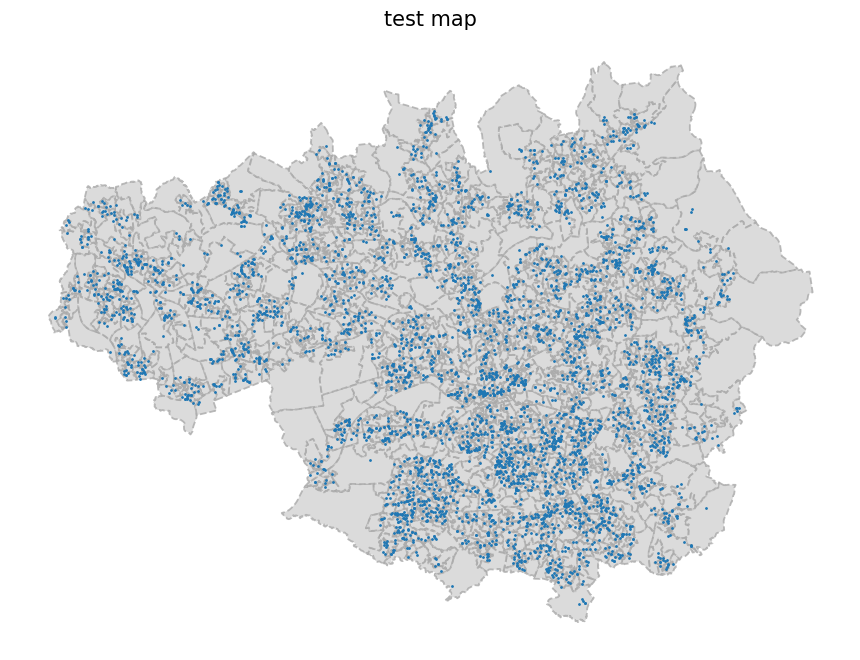

In [21]:
#house price data test visualization
f, ax = plt.subplots(1, figsize=(16, 8))
# define the basemap plot it on the sublot axis
base = gm_lsoa.plot(ax=ax,facecolor='lightgrey',alpha=0.8,
                         edgecolor='darkgrey',          # set border color
                         linewidth=1.3,              # set border length
                         linestyle='dashed')          # set border style

# plot the house location on the basemap axis, colour the location points by their saling price
hp_man.plot(ax=base,
             markersize=1,
             legend=False,
             )
# remove axis
ax.set_axis_off()
# add title
ax.set_title('test map', fontsize=15)
# show the map
plt.show()

根据可视化效果进行验证，可以看到Manchester的lsoa边界已经正确的裁切，房价数据点也均匀分布在Manchester区域内，进行到这里房屋的地理位置数据以及对应的房屋价格数据已经准备完毕，Manchester的losa边界也已完全处理完毕

下一步开始处理公交站点数据

In [9]:
pbtsp_all = pd.read_csv('/content/drive/MyDrive/Python_final/Stops.csv')
pbtsp_all.info()

<ipython-input-9-964e0fc6bc8c>:1: DtypeWarning: Columns (1,2,6,8,21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  pbtsp_all = pd.read_csv('/content/drive/MyDrive/Python_final/Stops.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433259 entries, 0 to 433258
Data columns (total 43 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ATCOCode                 433259 non-null  object 
 1   NaptanCode               407498 non-null  object 
 2   PlateCode                62892 non-null   object 
 3   CleardownCode            0 non-null       float64
 4   CommonName               433259 non-null  object 
 5   CommonNameLang           0 non-null       float64
 6   ShortCommonName          96576 non-null   object 
 7   ShortCommonNameLang      0 non-null       float64
 8   Landmark                 249347 non-null  object 
 9   LandmarkLang             0 non-null       float64
 10  Street                   409122 non-null  object 
 11  StreetLang               0 non-null       float64
 12  Crossing                 0 non-null       float64
 13  CrossingLang             0 non-null       float64
 14  Indi

由于数据太长以至于不能在colab中完整显示，因此在excel中打开，使用二者相结合着进行了观察

因为字段过多，在保证建模必要字段的基础上应尽可能精简数据，经过对字段进行分析保留以下字段并标注对应原因

1.CommonName - 每个站点独有的名称，用来后续对数据做标识

2.Easting, Northing - national grid 坐标，观察上面info信息可知经纬度信息存在大量null值，为保证数据完整性选择国家网格坐标来生成地理数据

3.StopType - 最重要的字段之一，代表了公交站点的类型，包括机场，火车站，公交站点等，对后续建模赋予权重有重要参考意义

4.Modification - The NaPTAN dataset is updated when information is provided by staff based throughout local authorities around the UK. 该字段为delete的值为无效数据，应当删掉

5.Status - 标识了当前公交站点的使用状况，inactive的为无效数据，应当删去

以上1/4/5用于清洗数据，2/3用于为后续创建地理数据提供关键参数

In [31]:
# 1. 首先进行数据清洗 - 保留需要的字段并删除无效数据
# 只保留需要的字段
pbtsp_cleaned = pbtsp_all[['CommonName', 'Easting', 'Northing', 'StopType', 'Modification', 'Status']]

# 移除无效数据 - Status为inactive的站点
pbtsp_cleaned = pbtsp_cleaned[pbtsp_cleaned['Status'] == 'active']

# 移除无效数据 - Modification为delete的站点
pbtsp_cleaned = pbtsp_cleaned[pbtsp_cleaned['Modification'] != 'delete']

# 确保有网格坐标数据
pbtsp_cleaned = pbtsp_cleaned.dropna(subset=['Easting', 'Northing'])

# 2. 直接使用网格坐标创建GeoDataFrame
pbtsp_gdf = gpd.GeoDataFrame(
    pbtsp_cleaned,
    geometry=gpd.points_from_xy(pbtsp_cleaned.Easting, pbtsp_cleaned.Northing),
    crs="EPSG:27700"  # British National Grid
)

# 3. 确保gm_lsoa和pbtsp_gdf使用相同的坐标系
if gm_lsoa.crs != "EPSG:27700":
    gm_lsoa = gm_lsoa.to_crs("EPSG:27700")

# 4. 检查gm_lsoa的范围
print("LSOA边界范围:", gm_lsoa.total_bounds)

# 5. 创建曼彻斯特区域边界
manchester_boundary = gm_lsoa.unary_union
# 添加小缓冲区以包含边界附近的站点（1000米）
manchester_buffer = manchester_boundary.buffer(1000)

# 6. 先进行空间筛选
# 只保留曼彻斯特区域内的站点
stops_in_manchester = pbtsp_gdf[pbtsp_gdf.geometry.intersects(manchester_buffer)]
print(f"曼彻斯特区域内的站点数量: {len(stops_in_manchester)}")

# 7. 然后筛选站点类型
selected_types = ['AIR', 'RLY', 'TMU', 'BST', 'BCT']
final_stops = stops_in_manchester[stops_in_manchester['StopType'].isin(selected_types)]

# 8. 检查筛选结果
print(f"筛选后站点数量: {len(final_stops)}")
print("按站点类型统计:")
print(final_stops['StopType'].value_counts())


final_stops.info()

LSOA边界范围: [351662.34339545 381166.04365763 406087.19083532 421037.68669397]


<ipython-input-31-02bf95fd5441>:29: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  manchester_boundary = gm_lsoa.unary_union


曼彻斯特区域内的站点数量: 15860
筛选后站点数量: 14979
按站点类型统计:
StopType
BCT    14585
TMU      264
RLY       99
BST       23
AIR        8
Name: count, dtype: int64
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 14979 entries, 27136 to 429712
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   CommonName    14979 non-null  object  
 1   Easting       14979 non-null  int64   
 2   Northing      14979 non-null  int64   
 3   StopType      14979 non-null  object  
 4   Modification  14979 non-null  object  
 5   Status        14979 non-null  object  
 6   geometry      14979 non-null  geometry
dtypes: geometry(1), int64(2), object(4)
memory usage: 936.2+ KB


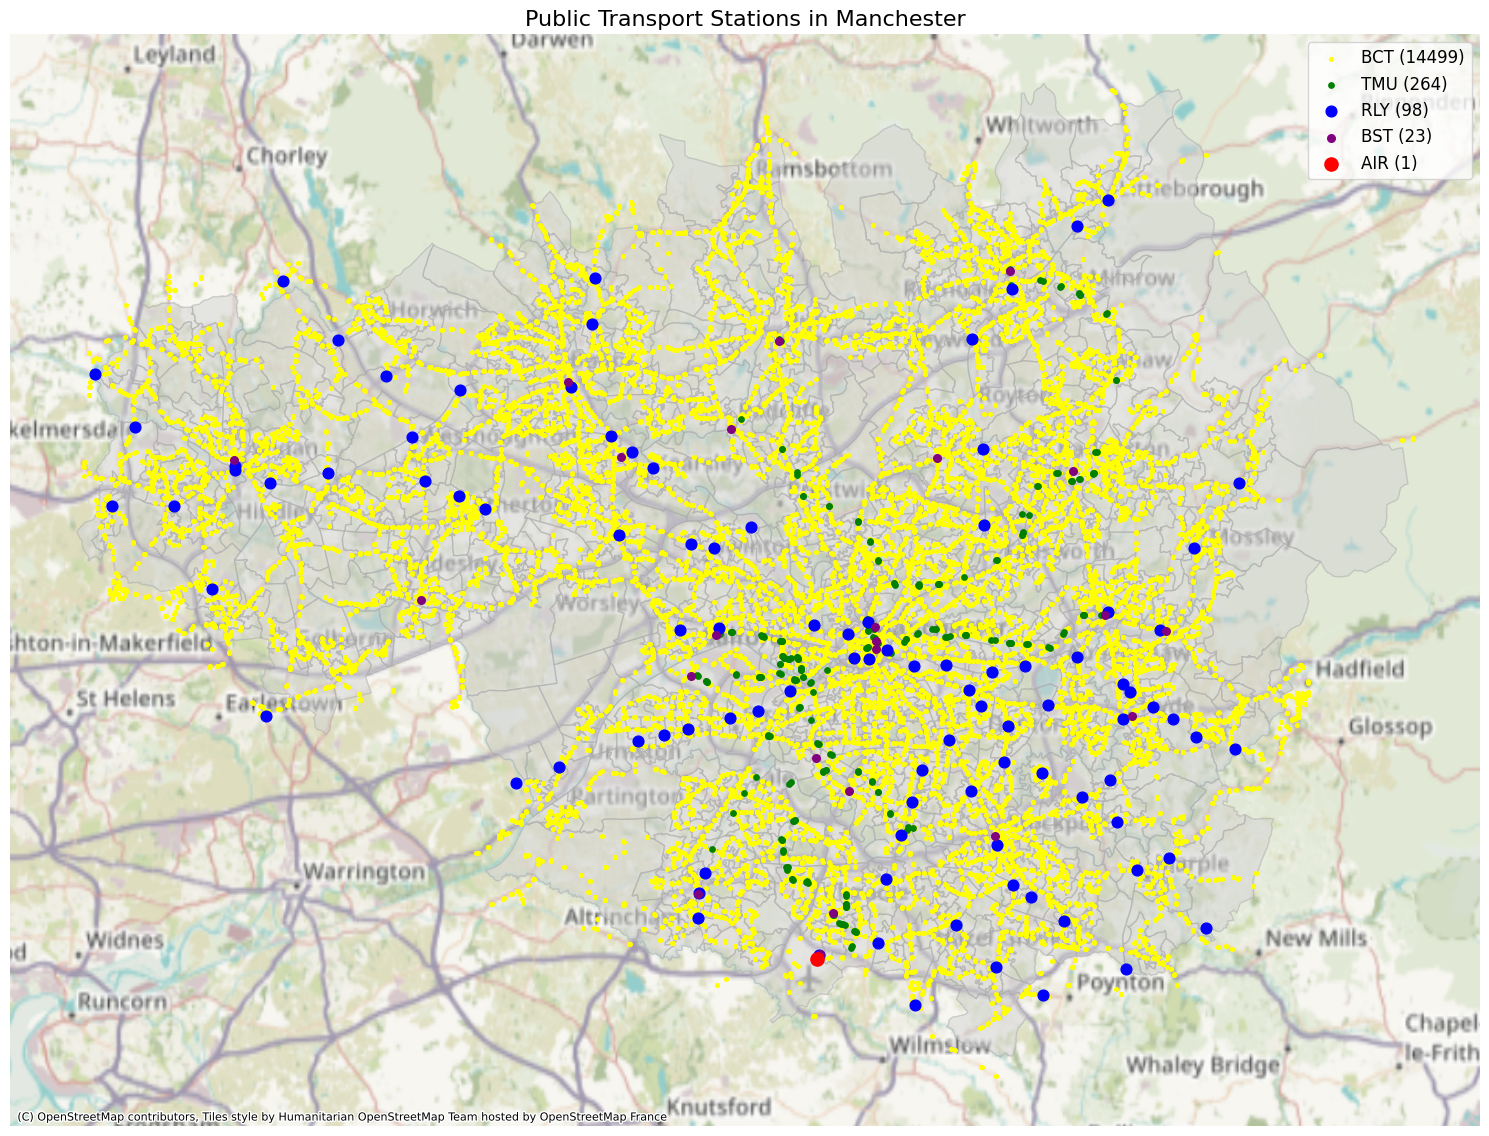

In [53]:
# 创建图形
fig, ax = plt.subplots(1, figsize=(15, 12))

# 设置颜色映射
colors = {'BCT': 'yellow','TMU': 'green','RLY': 'blue','BST': 'purple','AIR': 'red'}
#'BCT': 'yellow','TMU': 'green','RLY': 'blue','BST': 'purple','AIR': 'red'

# 绘制LSOA边界作为底图
gm_lsoa.plot(ax=ax, color='lightgrey', edgecolor='darkgrey', alpha=0.5)

# 按站点类型分组并绘制
for stop_type, color in colors.items():
    if stop_type in final_stops['StopType'].values:
        subset = final_stops[final_stops['StopType'] == stop_type]
        subset.plot(ax=ax, color=color, marker='o',
                   label=f"{stop_type} ({len(subset)})",
                   markersize=90 if stop_type == 'AIR' else
                              60 if stop_type == 'RLY' else
                              15 if stop_type == 'TMU' else
                              30 if stop_type == 'BST' else 7)

ctx.add_basemap(ax, crs=gm_lsoa.crs.to_string())

# 添加图例和标题
ax.legend(fontsize=12)
ax.set_title('Public Transport Stations in Manchester', fontsize=16)
ax.set_axis_off()

# 显示图形
plt.tight_layout()
plt.show()

在经过对公交站点的数据整理以及可视化之后，观察到公交站点点位均匀地分布于整个Manchester大都会区域，且符合路网的分布模式，说明数据的导入与清理获得了成功

然而，在分类数据中可以看到机场有8个点位，经过查询Manchester只有一个机场，因此使用commonname字段输出数据观察为何出现这种情况

In [43]:
# 筛选出StopType为'AIR'的站点
air_stops = final_stops[final_stops['StopType'] == 'AIR']
display(air_stops['CommonName'])

,CommonName
114395,Terminal One Access
114396,Terminal One Access
114397,Terminal One Access
114398,Terminal One Access
114399,Terminal Three Access
114400,Terminal Three Access
114401,Terminal Two Access
114402,Terminal Two Access


可以观察到，这八个air type的点并不都是机场，而是指代不同的航站楼入口，为避免对后续建模造成错误影响，需要对这八个点进行单一化处理

In [48]:
# 2. 筛选出机场站点
airport_terminals = final_stops[final_stops['StopType'] == 'AIR']
print(f"原始机场站点数量: {len(airport_terminals)}")

# 3. 计算机场站点的中心点
airport_center = airport_terminals.geometry.unary_union.centroid

# 4. 从数据中移除所有机场站点
final_stops = final_stops[final_stops['StopType'] != 'AIR']

# 5. 创建新的机场中心点记录
# 获取原始数据的列，以确保新记录有相同的列结构
columns = final_stops.columns.tolist()

# 创建新的机场记录，根据列结构填充数据
new_airport = {}
for col in columns:
    if col == 'CommonName':
        new_airport[col] = 'Manchester Airport'
    elif col == 'StopType':
        new_airport[col] = 'AIR'
    elif col == 'geometry':
        continue  # geometry将通过GeoDataFrame构造函数添加
    else:
        # 对其他列使用默认值或从原始机场数据中获取值
        if len(airport_terminals) > 0 and col in airport_terminals.columns:
            new_airport[col] = airport_terminals.iloc[0][col]
        else:
            new_airport[col] = None

# 创建新的机场中心点GeoDataFrame
airport_point = gpd.GeoDataFrame([new_airport], geometry=[airport_center], crs=final_stops.crs)

# 6. 将新的机场点添加到原始数据中
final_stops = pd.concat([final_stops, airport_point])

# 7. 重置索引（可选）
final_stops = final_stops.reset_index(drop=True)

原始机场站点数量: 8


<ipython-input-48-fab7f10cde1c>:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  airport_center = airport_terminals.geometry.unary_union.centroid


In [52]:
print(final_stops['StopType'].value_counts())

StopType
BCT    14499
TMU      264
RLY       98
BST       23
AIR        1
Name: count, dtype: int64


可以观察到机场航站楼已被取中心值为一个，至此数据的导入、清理、筛选，全部完成，下一步开始建模

##建模

对于本研究，如何选择合适的数据对每个房屋的公共交通可达性进行量化是一个难点，但并不是本次任务的重点，因此简单带过。
在经过研究后

This is an example block of mardown text I want to reference <a href="#ref1">[1]</a>. I might need to add some more citations <a href="#ref2">[2]</a><a href="#ref2">[3]</a>



Data Visualisation
- Don't forget to present your final two data visualisation (one spatial and one non-spatial) and the justifications about the decisions you made whilst preparing and visualising the data.

## References
<p><a href="add_url_here">[1]</a>Footnote citation goes here</p>
<p><a href="https://github.com/FrancescaPontin/GEOG5990">[2]</a>GEOG5990M course materials</p>
<p><a href="add_url_here">[3]</a>Citation 3</p>